<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, f1_score, roc_curve
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

<h2>Data Preparation</h2>

In [3]:
# Reading the csv file.
df = pd.read_csv('CHEMBL614725_MIA-PaCa-2_2class_pubchem_fp.csv')
df.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,bioactivity_class
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,active
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,active
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,active
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,active
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,active


<h2>Data Cleaning</h2>

In [4]:
df.isna().sum()

PubchemFP0           0
PubchemFP1           0
PubchemFP2           0
PubchemFP3           0
PubchemFP4           0
                    ..
PubchemFP877         0
PubchemFP878         0
PubchemFP879         0
PubchemFP880         0
bioactivity_class    0
Length: 882, dtype: int64

In [5]:
df.isnull().sum()

PubchemFP0           0
PubchemFP1           0
PubchemFP2           0
PubchemFP3           0
PubchemFP4           0
                    ..
PubchemFP877         0
PubchemFP878         0
PubchemFP879         0
PubchemFP880         0
bioactivity_class    0
Length: 882, dtype: int64

In [6]:
df.shape

(772, 882)

In [7]:
df['bioactivity_class'].value_counts()

inactive    386
active      386
Name: bioactivity_class, dtype: int64

In [27]:
# Train-Test split
x = df.iloc[:,:881]
y = pd.get_dummies(df['bioactivity_class'])['active']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

In [28]:
x_train.shape

(617, 881)

In [29]:
y_train.shape

(617,)

In [30]:
x_test.shape

(155, 881)

In [31]:
y_test.shape

(155,)

<h2>Data Modeling</h2>

Best Parameter for KNN, k = 11.0


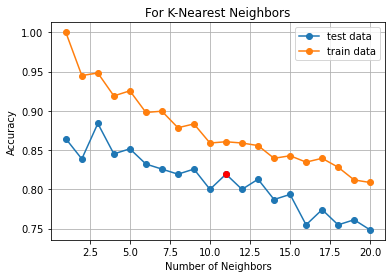

In [32]:
# KNN
# Hyper-tunning the 'n_neighbors' parameter
neighbors = list(range(1,21,1))
knn_accuracy_test = []
knn_accuracy_train = []
knn_df = pd.DataFrame(columns=['n_neighbors', 'test_Accuracy', 'train_accuracy'])
for i in neighbors:
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(x_train, y_train)
    knn_pred = knn_clf.predict(x_test)
    knn_acc = accuracy_score(y_test, knn_pred)
    knn_accuracy_test.append(knn_acc)
    knn_pred = knn_clf.predict(x_train)
    knn_acc = accuracy_score(y_train, knn_pred)
    knn_accuracy_train.append(knn_acc)
    
knn_df['n_neighbors'] = neighbors
knn_df['test_Accuracy'] = knn_accuracy_test
knn_df['train_accuracy'] = knn_accuracy_train
knn_df['difference'] = abs(knn_df['test_Accuracy'].values - knn_df['train_accuracy'].values)
knndf = knn_df[knn_df.iloc[:,1]<knn_df.iloc[:,2]]
k_best, k_accu_best = knndf.sort_values(['difference', 'test_Accuracy'], ascending=[True, False]).head(1)[['n_neighbors', 'test_Accuracy']].values[0]
print("Best Parameter for KNN, k =", k_best)
plt.plot(neighbors, knn_accuracy_test, label='test data', marker='o')
plt.plot(neighbors, knn_accuracy_train, label='train data', marker='o')
plt.plot(k_best, k_accu_best, marker='o', color='red')
plt.grid() 
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.title("For K-Nearest Neighbors")
plt.legend(loc='upper right')
plt.show()

In [33]:
knn_clf = KNeighborsClassifier(n_neighbors=11)
knn_clf.fit(x_train, y_train)
knn_pred = knn_clf.predict(x_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_acc

0.8193548387096774

Best Parameter for Support Vector Machine(SVC) =  [kernel = scale, gamma = rbf]


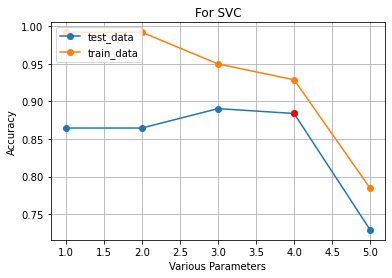

In [34]:
# Support Vector Classifier(SVC)
from sklearn.svm import SVC
# Hyper-tunning the 'kernel' and 'gamma' parameter
svc_dict = {'auto': ['linear'], 'scale': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_accuracy_test = []
svc_accuracy_train = []
svc_df = pd.DataFrame(columns=['Parameters', 'test_Accuracy', 'train_Accuracy'])
parameter = []
cnt = []
count = 0
for i in svc_dict:
    for j in svc_dict[i]:
        count+=1
        svc_clf = SVC(kernel=j, gamma=i, random_state=100)
        svc_clf.fit(x_train, y_train)
        svc_pred = svc_clf.predict(x_test)
        svc_acc = accuracy_score(y_test, svc_pred)
        svc_accuracy_test.append(svc_acc)
        svc_pred = svc_clf.predict(x_train)
        svc_acc = accuracy_score(y_train, svc_pred)
        svc_accuracy_train.append(svc_acc)
        cnt.append(count)
        para = '[kernel = '+str(i)+', gamma = '+str(j)+']'
        parameter.append(para)
svc_df['Parameters'] = parameter
svc_df['test_Accuracy'] = svc_accuracy_test
svc_df['train_Accuracy'] = svc_accuracy_train
svc_df['difference'] = abs(svc_df['test_Accuracy'] - svc_df['train_Accuracy'])
svc_df["count"] = cnt
svcdf = svc_df[svc_df.iloc[:,1]<svc_df.iloc[:,2]]
svc_best, svc_accu_best, best_para = svcdf.sort_values(['difference', 'test_Accuracy'], ascending=[True, False]).head(1)[['count', 'test_Accuracy', 'Parameters']].values[0]
print('Best Parameter for Support Vector Machine(SVC) = ', best_para)
plt.plot(cnt, svc_accuracy_test, label='test_data', marker ='o')
plt.plot(cnt, svc_accuracy_train, label='train_data', marker='o')
plt.plot(svc_best, svc_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("Accuracy")
plt.title("For SVC")
plt.legend(loc='upper left')
plt.show()

In [35]:
svc_clf = SVC(kernel='rbf', random_state=100)
svc_clf.fit(x_train, y_train)
svc_pred = svc_clf.predict(x_test)
svc_acc = accuracy_score(y_test, svc_pred)
svc_acc

0.8838709677419355

c:\users\ayush\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\ayush\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\ayush\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The 

Best Parameters for Logistic Regression = [penalty = l1, solver = saga]


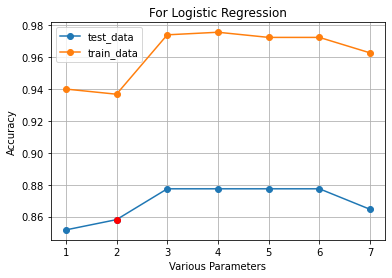

In [36]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Hyper-tunning the 'penalty' and 'solver' parameter
lr_dict = {'l1': ['liblinear', 'saga'], 'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_accuracy_test = []
lr_accuracy_train = []
lr_accuracy_cv = []
lr_df = pd.DataFrame(columns=['Parameters', 'test_Accuracy', 'train_Accuracy'])
parameter = []
cnt = []
count = 0
for i in lr_dict:
    for j in lr_dict[i]:
        count+=1
        lr_clf = LogisticRegression(penalty=i, solver=j, random_state=120)
        lr_clf.fit(x_train, y_train)
        lr_pred = lr_clf.predict(x_test)
        lr_acc = accuracy_score(y_test, lr_pred)
        lr_accuracy_test.append(lr_acc)
        lr_pred = lr_clf.predict(x_train)
        lr_acc = accuracy_score(y_train, lr_pred)
        lr_accuracy_train.append(lr_acc)
        cnt.append(count)
        para = '[penalty = '+str(i)+', solver = '+str(j)+']'
        parameter.append(para)

lr_df['Parameters'] = parameter
lr_df['test_Accuracy'] = lr_accuracy_test
lr_df['train_Accuracy'] = lr_accuracy_train
lr_df['difference'] = abs(lr_df['test_Accuracy'] - lr_df['train_Accuracy'])
lr_df["count"] = cnt
lrdf = lr_df[lr_df.iloc[:,1]<lr_df.iloc[:,2]]
lr_best, lr_accu_best, best_para = lrdf.sort_values(['difference', 'test_Accuracy'], ascending=[True, False]).head(1)[['count', 'test_Accuracy', 'Parameters']].values[0]
print('Best Parameters for Logistic Regression =', best_para)
plt.plot(cnt, lr_accuracy_test, label='test_data', marker ='o')
plt.plot(cnt, lr_accuracy_train, label='train_data', marker='o')
plt.plot(lr_best, lr_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("Accuracy")
plt.title("For Logistic Regression")
plt.legend(loc='upper left')
plt.show()

In [37]:
lr_clf = LogisticRegression(penalty='l1', solver='saga', random_state=120)
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_acc

c:\users\ayush\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.8580645161290322

Best Parameter for Decision Tree = [criterion = gini, max_depth = 5, min_sample_leaf = 1, min_sample_split = 4]


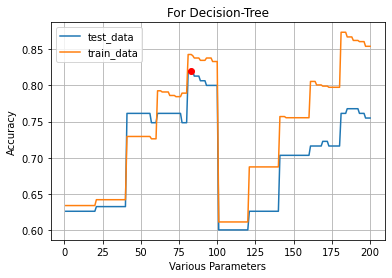

In [65]:
# Decision Tree
# Hyper-tunning the 'criterion', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
max_depth = [1,2,3,4,5]
min_sample_leaf = [1,2,3,4,5]
min_sample_split = [2,3,4,5]
dt_accuracy_test = []
dt_accuracy_train = []
parameter = []
dt_df = pd.DataFrame(columns=['Parameters', 'test_Accuracy', 'train_Accuracy'])
count = 0
cnt = []
for i in criterion:
    for j in max_depth:
        for k in min_sample_leaf:
            for l in min_sample_split:
                count+=1
                dt_clf = DecisionTreeClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, random_state=20)
                dt_clf.fit(x_train, y_train)
                dt_pred = dt_clf.predict(x_test)
                dt_acc = accuracy_score(y_test, dt_pred)
                dt_accuracy_test.append(dt_acc)
                dt_pred = dt_clf.predict(x_train)
                dt_acc = accuracy_score(y_train, dt_pred)
                dt_accuracy_train.append(dt_acc)
                cnt.append(count)
                para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+']'
                parameter.append(para)

dt_df['Parameters'] = parameter
dt_df['test_Accuracy'] = dt_accuracy_test
dt_df['train_Accuracy'] = dt_accuracy_train
dt_df['difference'] = abs(dt_df['test_Accuracy'] - dt_df['train_Accuracy'])
dt_df["count"] = cnt
dtdf = dt_df[dt_df.iloc[:,1]<dt_df.iloc[:,2]]
dt_best, dt_accu_best, best_para = dtdf.iloc[0:int(dtdf.shape[0]*0.50)].sort_values('test_Accuracy', ascending=False).head(1)[['count', 'test_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Decision Tree =", best_para)
plt.plot(cnt, dt_accuracy_test, label='test_data')
plt.plot(cnt, dt_accuracy_train, label='train_data')
plt.plot(dt_best, dt_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("Accuracy")
plt.title("For Decision-Tree")
plt.legend(loc='upper left')
plt.show()

In [66]:
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=4, random_state=20)
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)
dt_acc = accuracy_score(y_test, dt_pred)
dt_acc

0.8193548387096774

In [67]:
# Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Best Accuracy for Random Forest:", rf_acc)

Best Accuracy for Random Forest: 0.9032258064516129


In [68]:
# Gradient-Boost Classifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train, y_train)
pred = gb_clf.predict(x_test)
acc_gb = accuracy_score(y_test, pred)
print("Accuracy for GradientBoosting:",acc_gb)

Accuracy for GradientBoosting: 0.8387096774193549


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [7]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=150, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [30]:
# Deep Neural Network(DNN)
model = keras.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=[len(x_train.keys())]),
    layers.Dense(128, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.001))
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [32]:
history = model.fit(x_train, y_train, epochs=500, validation_split=0.2, callbacks=callback)

Epoch 1/500
16/16 [==============================] - 0s 15ms/step - loss: 1.1825 - accuracy: 0.5132 - val_loss: 1.1105 - val_accuracy: 0.6048
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 1.0511 - accuracy: 0.6268 - val_loss: 1.0273 - val_accuracy: 0.6290
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.9252 - accuracy: 0.6998 - val_loss: 0.9022 - val_accuracy: 0.7177
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.7571 - accuracy: 0.8276 - val_loss: 0.8297 - val_accuracy: 0.7984
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 0.6672 - accuracy: 0.8580 - val_loss: 0.7594 - val_accuracy: 0.8065
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5611 - accuracy: 0.9047 - val_loss: 0.7568 - val_accuracy: 0.8468
Epoch 7/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5103 - accuracy: 0.9290 - val_loss: 0.7251 - val_accuracy: 0.8548
Epoch 8/500


16/16 [==============================] - 0s 6ms/step - loss: 0.0833 - accuracy: 0.9980 - val_loss: 1.0050 - val_accuracy: 0.8387
Epoch 116/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0712 - accuracy: 1.0000 - val_loss: 1.1281 - val_accuracy: 0.8548
Epoch 117/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 1.0000 - val_loss: 1.1990 - val_accuracy: 0.8468
Epoch 118/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0677 - accuracy: 1.0000 - val_loss: 1.2624 - val_accuracy: 0.8387
Epoch 119/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 1.2610 - val_accuracy: 0.8468
Epoch 120/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0654 - accuracy: 1.0000 - val_loss: 1.2762 - val_accuracy: 0.8548
Epoch 121/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0643 - accuracy: 1.0000 - val_loss: 1.2736 - val_accuracy: 0.8629
Epoch 122/500

In [33]:
np.mean(history.history["accuracy"])

0.9870417996176651

In [34]:
np.mean(history.history["val_accuracy"])

0.8505904466978141

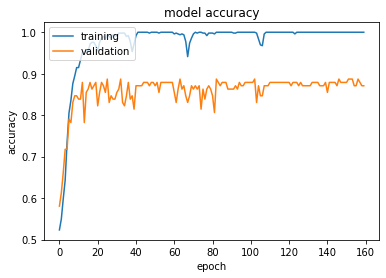

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

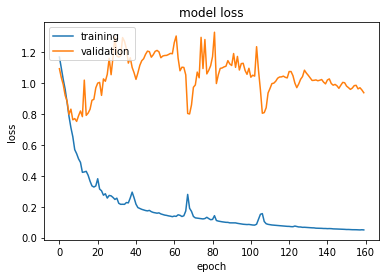

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [83]:
# import pickle
# with open("gb.pkl", "wb") as file:
#     pickle.dump(gb_clf, file)

In [84]:
# x_train.to_csv('x_train.csv')
# y_train.to_csv('y_train.csv')
# x_test.to_csv('x_test.csv')
# y_test.to_csv('y_test.csv')

In [5]:
x_train = pd.read_csv('x_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
x_test = pd.read_csv('x_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [2]:
# Testing all the models on the test dataset.
x_train = pd.read_csv('x_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
x_test = pd.read_csv('x_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()



import pickle
with open("svc.pkl", 'rb') as file:
    pickle_model_svc = pickle.load(file)
svc_ac = accuracy_score(y_test, pickle_model_svc.predict(x_test))
svc_precision = precision_score(y_test, pickle_model_svc.predict(x_test))
svc_recall = recall_score(y_test, pickle_model_svc.predict(x_test))
svc_f1 = f1_score(y_test, pickle_model_svc.predict(x_test))
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test, pickle_model_svc.predict(x_test)) 
svc_auc = auc(svc_fpr, svc_tpr)
                          

with open("rf.pkl", 'rb') as file:
    pickle_model_rf = pickle.load(file)
rf_ac = accuracy_score(y_test, pickle_model_rf.predict(x_test))
rf_precision = precision_score(y_test, pickle_model_rf.predict(x_test))
rf_recall = recall_score(y_test, pickle_model_rf.predict(x_test))
rf_f1 = f1_score(y_test, pickle_model_rf.predict(x_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, pickle_model_rf.predict(x_test)) 
rf_auc = auc(rf_fpr, rf_tpr)

with open("lr.pkl", 'rb') as file:
    pickle_model_lr = pickle.load(file)
lr_ac = accuracy_score(y_test, pickle_model_lr.predict(x_test))
lr_precision = precision_score(y_test, pickle_model_lr.predict(x_test))
lr_recall = recall_score(y_test, pickle_model_lr.predict(x_test))
lr_f1 = f1_score(y_test, pickle_model_lr.predict(x_test))
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, pickle_model_lr.predict(x_test)) 
lr_auc = auc(lr_fpr, lr_tpr)

with open("gb.pkl", 'rb') as file:
    pickle_model_gb = pickle.load(file)
gb_ac = accuracy_score(y_test, pickle_model_gb.predict(x_test))
gb_precision = precision_score(y_test, pickle_model_gb.predict(x_test))
gb_recall = recall_score(y_test, pickle_model_gb.predict(x_test))
gb_f1 = f1_score(y_test, pickle_model_gb.predict(x_test))
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, pickle_model_gb.predict(x_test)) 
gb_auc = auc(gb_fpr, gb_tpr)

with open("dt.pkl", 'rb') as file:
    pickle_model_dt = pickle.load(file)
dt_ac = accuracy_score(y_test, pickle_model_dt.predict(x_test))
dt_precision = precision_score(y_test, pickle_model_dt.predict(x_test))
dt_recall = recall_score(y_test, pickle_model_dt.predict(x_test))
dt_f1 = f1_score(y_test, pickle_model_dt.predict(x_test))
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, pickle_model_dt.predict(x_test)) 
dt_auc = auc(dt_fpr, dt_tpr)

with open("knn.pkl", 'rb') as file:
    pickle_model_knn = pickle.load(file)
knn_ac = accuracy_score(y_test, pickle_model_knn.predict(x_test))
knn_precision = precision_score(y_test, pickle_model_knn.predict(x_test))
knn_recall = recall_score(y_test, pickle_model_knn.predict(x_test))
knn_f1 = f1_score(y_test, pickle_model_knn.predict(x_test))
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, pickle_model_knn.predict(x_test)) 
knn_auc = auc(knn_fpr, knn_tpr)

dnn_model = load_model('dnn.h5')
dnn_pred = dnn_model.predict_classes(x_test)
dnn_ac = accuracy_score(y_test, dnn_pred)
dnn_precision = precision_score(y_test, dnn_pred)
dnn_recall = recall_score(y_test, dnn_pred)
dnn_f1 = f1_score(y_test, dnn_pred)
dnn_fpr, dnn_tpr, dnn_thresholds = roc_curve(y_test, dnn_pred) 
dnn_auc = auc(dnn_fpr, dnn_tpr)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [3]:
all_accuracy = [dnn_ac, dt_ac, gb_ac, knn_ac, lr_ac, rf_ac, svc_ac]
all_precision = [dnn_precision, dt_precision, gb_precision, knn_precision, lr_precision, rf_precision, svc_precision]
all_recall = [dnn_recall, dt_recall, gb_recall, knn_recall, lr_recall, rf_recall, svc_recall]
all_f1 = [dnn_f1, dt_f1, gb_f1, knn_f1, lr_f1, rf_f1, svc_f1]
all_auc = [dnn_auc, dt_auc, gb_auc, knn_auc, lr_auc, rf_auc, svc_auc]
models = ["DNN", "Decision-Tree", "Gradient Boosting", "KNN", "Logistic Regression", "Random-Forest", "SVM"]
data = {'Models':models, 'Accuracy':all_accuracy, "Precision":all_precision, "Recall":all_recall, "F1":all_f1, "AUC":all_auc}
dfg = pd.DataFrame(data, columns=['Models',"Accuracy", "Precision", "Recall", "F1", "AUC"])
display(dfg.style.apply(lambda x: ['background: lightblue' if i == max(dfg["Accuracy"]) else '' for i in dfg["Accuracy"]]))

,Models,Accuracy,Precision,Recall,F1,AUC
0,DNN,0.890323,0.905405,0.870130,0.887417,0.890193
1,Decision-Tree,0.819355,0.865672,0.753247,0.805556,0.818931
2,Gradient Boosting,0.838710,0.842105,0.831169,0.836601,0.838661
3,KNN,0.819355,0.901639,0.714286,0.797101,0.818681
4,Logistic Regression,0.858065,0.857143,0.857143,0.857143,0.858059
5,Random-Forest,0.903226,0.907895,0.896104,0.901961,0.903180
6,SVM,0.883871,0.893333,0.870130,0.881579,0.883783


In [22]:
# model.save('dnn.h5')

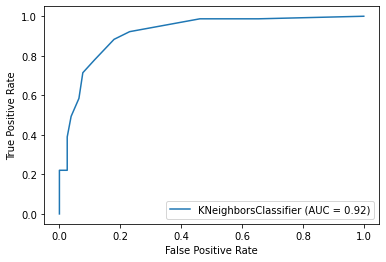

In [4]:
# ROC curve for KNN model
from sklearn.metrics import plot_roc_curve
plot_roc_curve(pickle_model_knn, x_test, y_test)

In [5]:
x_train

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
417,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
586,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
73,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
54,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
641,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
622,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
208,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
